In [71]:
# ARMA estimation, forcast and order selection
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARMA
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm #A tqdm progress bar shows you how much time has elapsed and the estimated time remaining for the iterable
import sklearn.metrics as skmetrics #For evaluation metrics
from fbprophet import Prophet

import warnings                               
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error

# FB Prophet Univariate Model

In [43]:
TARGET = 'MedianSoldPrice_AllHomes.California'

In [44]:
train = pd.read_csv('zillow-carlifornia.csv', parse_dates=True).set_index('Date')

Drop NA in train set, since they are in the test set

In [52]:
train = train.dropna(subset = [TARGET], axis = 0)

In [54]:
test = pd.read_csv('test.csv', parse_dates=True).set_index('Month')

In [55]:
train_proph = train.reset_index().rename({TARGET:"y", 'Date':'ds'}, axis = 1)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


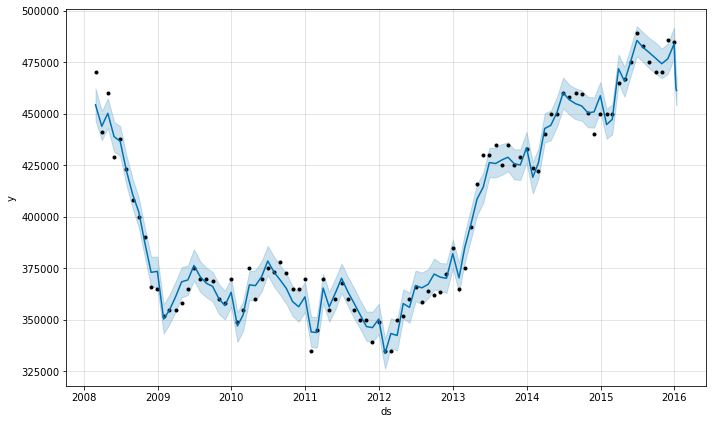

In [56]:
model_1=Prophet()
model_1.fit(train_proph)
future = model_1.make_future_dataframe(periods=len(test))
forecast = model_1.predict(future)
model_1.plot(forecast)
plt.show()

In [74]:
forecast_test = pd.Series((forecast.iloc[-len(test):,:].yhat.values), index = test.index)

In [78]:
rmse = mean_squared_error(test, forecast_test, squared=False)

In [80]:
print(f"RMSE of Prophet: {rmse:.2f}")

RMSE of Prophet: 38070.81


# SARIMA Model